In [1287]:

import os, glob
import numpy 
import tifffile
import pandas
import phate
import seaborn
import matplotlib
import io

from matplotlib import pyplot
from skimage import measure
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.metrics import silhouette_score
from scipy.spatial import distance
from scipy.stats import gaussian_kde
from scipy.cluster.hierarchy import cophenet, linkage
from scipy import stats

import sys
to_insert = "../.."
while to_insert in sys.path:
    sys.path.remove(to_insert)
sys.path.insert(0, to_insert)

from train import preprocess_stream

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

Trying to register the cmap 'nice-prism' which already exists.
Trying to register the cmap 'nice-prism_r' which already exists.


In [1288]:
def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    dirname = os.path.dirname(savepath)
    basename = os.path.basename(savepath)    
    
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
    if save_white:
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))  

# Per video analysis
COLORS = {
    "/ctrl" : "tab:blue",
    "/cltp" : "tab:orange"
}

import numpy

from matplotlib import pyplot
from scipy import stats
import scikit_posthocs

def fit_model(data):
    """
    This function implements the linear model for the one-way ANOVA.

    :param data: A list of list of each observations in each treatments

    :returns : The fitted model, the residuals, the standardize residuals and
               the quantiles for probability plot

    Ref : https://onlinelibrary.wiley.com/doi/full/10.1111/jac.12220
    """
    fitted, residuals, standard_residuals, quantiles = [],[],[],[]
    for treatment in data:
        treatment = numpy.array(treatment)
        mean = numpy.mean(treatment)
        fitted.append(mean)
        residuals.append(treatment - mean)
        sr = (treatment - mean) / numpy.std(treatment)
        standard_residuals.append(sr)
        quantiles.append(stats.probplot(sr, dist="norm", fit=True))
    return fitted, residuals, standard_residuals, quantiles


def verify_normality(samples, alpha=0.05):
    """
    Verifies the normality of the data
    """
    # print([stats.shapiro(sample)[1] for sample in samples])
    return [stats.shapiro(sample)[1] > alpha for sample in samples]


def get_significance(samples, labels=None, show_qq=False, force_normal_test=False, show_sr=False, verbose=False, **posthoc_kwargs):
    """
    Computes a statistic analysis of the given samples.
    :param samples: A list of sample observations
    :param show_qq: Wheter to show the quantiles
    :param force_normal_test: Wheter to force the normal test
    :param show_sr: Wheter to show standard residuals
    :param verbose: Wheter to use verbose
    """
    _print = print if verbose else lambda *args, **kwargs : None # Defines the level of verbosity
    fitted, residuals, standard_res, quantiles = fit_model(samples)
    if show_qq:
        fig, ax = pyplot.subplots()
        for params, fit in quantiles:
            ax.scatter(params[0], params[1], facecolor="white", edgecolor="black")
        lims = [
            numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, color="gray", linestyle="dashed")
        ax.set_title("QQ-Plot")
    if show_sr:
        fig, ax = pyplot.subplots()
        ax.boxplot(standard_res)

    # print([fit[2] for params, fit in quantiles])
    # normality = all([fit[2] > 0.9 for params, fit in quantiles])
    normality = all(verify_normality(standard_res))
    if normality or force_normal_test :
        _print("The standardize residuals are normaly distributed.")
        statistic, pvalue = stats.f_oneway(*samples)
        if pvalue > 0.05:
            _print("The one-way ANOVA test that two or more groups have the same " +
            "population mean cannot be rejected with alpha confidence of 0.05.\n" +
            "\tpvalue : {}".format(pvalue))
            pvalues = numpy.ones((len(samples), len(samples)))
        else:
            _print("The null hypothesis can be rejected from the ANOVA one way test.\n"+
                    "\tpvalue : {}".format(pvalue))
            _print("Posthoc ttest is computed on the data")
            pvalues = scikit_posthocs.posthoc_ttest(samples, **posthoc_kwargs)
            _print("Posthoc t-test results\n" +
                    "\tpvalues : {}".format(pvalues))
    else :
        _print("The standardize residuals are not normaly distributed.")
        statistics, pvalue = stats.kruskal(*samples)
        if pvalue > 0.05:
            _print("The null hypothesis cannot be rejected from the Kruskal-Wallis H-test.\n" + 
                  "\tpvalue : {}".format(pvalue))
            pvalues = numpy.ones((len(samples), len(samples)))
        else:
            _print("The null hypothesis can be rejected from the Kruskal-Wallis H-test.\n"+
                    "\tpvalue : {}".format(pvalue))
            _print("Posthoc Dunn is computed on the data.")
            pvalues = scikit_posthocs.posthoc_dunn(samples, **posthoc_kwargs)
            _print("Posthoc Dunn results\n" +
                    "\tpvalues : {}".format(pvalues))            
    
    if isinstance(pvalues, numpy.ndarray):
        pvalues = pandas.DataFrame(pvalues)

    if isinstance(labels, list):
        pvalues.index = labels
        pvalues.columns = labels
    
    combinations = [(i, j) for i in range(len(samples)) for j in range(i + 1, len(samples))]
    significance = []
    for (i, j) in combinations:
        pvalue = pvalues.iloc[i, j]
        if pvalue <= 0.001:
            significance.append((pvalue, 3, i, j))
        elif pvalue <= 0.01:
            significance.append((pvalue, 2, i, j))
        elif pvalue <= 0.05:
            significance.append((pvalue, 1, i, j))
        else:
            significance.append((pvalue, 0, i, j))
    return significance, pvalues

def plot_pvalues(pvalues):
    fig, ax = pyplot.subplots(figsize=(5, 5))
    cmap = ['1', '#aaaaaa',  '#08306b',  '#4292c6', '#c6dbef']
    # cmap = ['white', 'red', 'black', 'yellow', 'purple']
    heatmap_args = {
        'cmap': cmap, 
        'linewidths': 1.0, 'linecolor': '0.', 
        'clip_on': True, 'square': True, 
        'flat' : False,
    }
    ax, cbar = scikit_posthocs.sign_plot(pvalues, ax=ax, **heatmap_args)

    # Strange bug ... do it by thyself
    cbar.remove()
    cbar_ax = fig.add_axes([0.95, 0.35, 0.04, 0.3])
    cbar = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=(matplotlib.colors.ListedColormap(cmap[2:] + [cmap[1]])), norm=matplotlib.colors.NoNorm(),
                        boundaries=[0, 1, 2, 3, 4])
    cbar.set_ticks(list(numpy.linspace(0, 3, 4)), labels=[
                   'p < 0.001', 'p < 0.01', 'p < 0.05', 'NS'])
    cbar.outline.set_linewidth(1)
    cbar.outline.set_edgecolor('0.5')
    cbar.ax.tick_params(size=0)

    pyplot.draw()    
    return fig, ax

In [1368]:
PATH = "../../../data"
EXPERIMENT = "ctrl-cltp"
MODEL_NAME = "unet3D-ZeroCostDL4Mic_subset-0.25-1_1-64_46"
# MODEL_NAME = "StarDist3D"
EXPERIMENT_PATH = os.path.join(PATH, "experiments", EXPERIMENT)

PROPERTIES=[
    "label", 
    "area", 
    "axis_major_length", 
    "axis_minor_length", 
    "bbox", 
    "centroid", 
    "weighted_centroid",    
    "intensity_max", 
    "intensity_min",
    "intensity_mean",
    "moments",
    "solidity"
]
# Filter small regions
POSTPROCESS_PARAMS = {
    "minimal_time" : 2,
    "minimal_height" : 3,
    "minimal_width" : 3
}

try:
    with open(os.path.join(PATH, "baselines", "ZeroCostDL4Mic", MODEL_NAME, "optimized-threshold-segmentation"), "r") as file:
        THRESHOLD = float(file.readline())
except FileNotFoundError:
    THRESHOLD = 0.5
    
def filter_regionprops(regionprops, constraints):
    updated_regionprops, remove_coords = [], []
    for rprop in regionprops:
        t1, h1, w1, t2, h2, w2 = rprop.bbox
        lenT = t2 - t1
        lenH = h2 - h1
        lenW = w2 - w1
        should_remove = False
        if "minimal_time" in constraints:
            if lenT < constraints["minimal_time"]:
                should_remove = True
            if lenH < constraints["minimal_height"]:
                should_remove = True
            if lenW < constraints["minimal_width"]:
                should_remove = True
        if should_remove:
            remove_coords.extend(rprop.coords)
        else:
            updated_regionprops.append(rprop)
    return updated_regionprops

In [1369]:
movie_files = glob.glob(os.path.join(EXPERIMENT_PATH, "**/*.tif"), recursive=True)
prediction_files = [file.replace("experiments", f"experiments/Analysis/{MODEL_NAME}").replace(".tif", "_prediction.tif") for file in movie_files]
out = defaultdict(list)
for movie_file, prediction_file in zip(tqdm(movie_files), prediction_files):
    
    if not os.path.isfile(prediction_file):
        continue

    stream = preprocess_stream(tifffile.imread(movie_file))
    prediction = tifffile.imread(prediction_file)
    if numpy.issubdtype(prediction.dtype, numpy.floating):
        prediction = prediction > THRESHOLD
        label = measure.label(prediction)
    else:
        label = prediction
    
    regionprops = measure.regionprops(label, intensity_image=stream)
    regionprops = filter_regionprops(regionprops, POSTPROCESS_PARAMS)
    
    regionprops_table = {prop : [getattr(rprop, prop) for rprop in regionprops] for prop in PROPERTIES}
    
    # Intensity profiles
    profiles = []
    for rprop in regionprops:
        intensity = rprop.image_intensity * rprop.image
        profile = numpy.mean(intensity, axis=(-2, -1))
        profiles.append(profile)
    regionprops_table["intensity-profile"] = profiles
    
    condition = os.path.dirname(movie_file).split(EXPERIMENT)[-1]
    regionprops_table["image-id"] = [
        movie_file for _ in range(len(regionprops))
    ]

    out[condition].append(regionprops_table)


  0%|          | 0/110 [00:00<?, ?it/s]

In [1370]:
import pickle
with open(os.path.join(EXPERIMENT_PATH, f"{EXPERIMENT}-{MODEL_NAME}.pkl"), "wb") as file:
    pickle.dump(out, file)

In [1371]:
import pickle
with open(os.path.join(EXPERIMENT_PATH, f"{EXPERIMENT}-{MODEL_NAME}.pkl"), "rb") as file:
    out = pickle.load(file)
print(EXPERIMENT_PATH)

../../../data/experiments/ctrl-cltp


In [1372]:
# Combines all data into a single dataframe
n_neighbors = 1
data = []
for key, values in out.items():
    for value in values:
        if len(value["label"]) < 1:
            continue
            
        # Nearest neighbors calculation        
        centroids = numpy.array([value["weighted_centroid"][i] for i in range(len(value["label"]))])
        distances = distance.cdist(centroids, centroids)
        mask = numpy.eye(len(distances), dtype=bool)
        distances[mask] = numpy.max(distances)
        distances = numpy.sort(distances, axis=-1)

        # Spatial neighbors calculation
        centroids = numpy.array([value["weighted_centroid"][i][1:] for i in range(len(value["label"]))])
        spatial_distances = distance.cdist(centroids, centroids)
        mask = numpy.eye(len(spatial_distances), dtype=bool)
        spatial_distances[mask] = numpy.max(spatial_distances)
        spatial_distances = numpy.sort(spatial_distances, axis=-1)
        
        for i in range(len(value["label"])):
            t1, h1, w1, t2, h2, w2 = value["bbox"][i]
            t, y, x = value["weighted_centroid"][i]     
            aspect_ratio = value["axis_minor_length"][i] / value["axis_major_length"][i]
            duration = t2 - t1            
            data.append({
                "neuron-id" : int(value["image-id"][i].split("/")[-1].split("-")[0]),
                "condition" : key,
                "image-id" : value["image-id"][i],
                "t" : t,
                "y" : y,
                "x" : x,
                "area" : value["area"][i],
                "intensity_mean" : value["intensity_mean"][i],
                "intensity_max" : value["intensity_max"][i],  
                "major" : value["axis_major_length"][i],
                "minor" : value["axis_minor_length"][i],
                "duration" : duration,
                "aspect" : aspect_ratio,
                "spatial-aspect" : min(h2 - h1, w2 - w1) / max(h2 - h1, w2 - w1),
                "solidity" : value["solidity"][i],
                "integrated_profile_intensity" : numpy.sum(value["intensity-profile"][i]),
                "max_profile_intensity" : numpy.max(value["intensity-profile"][i]),                
                "std_profile_intensity" : numpy.std(value["intensity-profile"][i]),
                **{f"nn-{n + 1}" : distances[i, min(n, distances.shape[-1]-1)] for n in range(n_neighbors)},
                **{f"spatial-nn-{n + 1}" : spatial_distances[i, min(n, spatial_distances.shape[-1]-1)] for n in range(n_neighbors)},
                "frequency" : numpy.sum(spatial_distances[i] < 6),
            })
df = pandas.DataFrame(data)

df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
df.dropna(inplace=True)
print(df.head())
print(df.shape)

   neuron-id       condition  \
0        138  /cltp-baseline   
1        138  /cltp-baseline   
2        138  /cltp-baseline   
3        138  /cltp-baseline   
4        138  /cltp-baseline   

                                            image-id          t           y  \
0  ../../../data/experiments/ctrl-cltp/cltp-basel...   1.732011  298.768276   
1  ../../../data/experiments/ctrl-cltp/cltp-basel...   8.524320   36.575402   
2  ../../../data/experiments/ctrl-cltp/cltp-basel...   9.565095   85.000458   
3  ../../../data/experiments/ctrl-cltp/cltp-basel...  23.585265  101.357803   
4  ../../../data/experiments/ctrl-cltp/cltp-basel...  25.487390  217.433756   

            x   area  intensity_mean  intensity_max      major  ...  duration  \
0  353.917867  987.0        0.766267       6.824440  24.665383  ...         6   
1  125.278240  344.0        1.434752       4.235244  11.672496  ...         7   
2  359.554260   92.0        1.407660       3.146544   6.884579  ...         4   
3  500.8

In [1373]:
# Ensure all before-after available
for condition in ["ctrl", "cltp"]:
    mask = df["condition"].str.contains(condition)
    subdf = df[mask]
    uniques = []
    for condition in subdf["condition"].unique():
        mask = subdf["condition"] == condition
        uniques.append(set(subdf[mask]["neuron-id"].unique()))
    all_neurons = set.union(*uniques)
    keep_neurons = set.intersection(*uniques)
    remove_neurons = all_neurons - keep_neurons
    for neuron_id in remove_neurons:
        remove_mask = df["neuron-id"] == neuron_id
        df.drop(df[remove_mask].index, inplace=True)
        df.reset_index(inplace=True, drop=True)
print(df.shape)

(7385, 21)


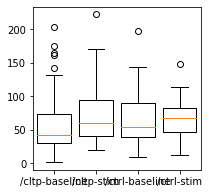

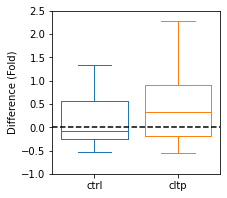

WilcoxonResult(statistic=66.0, pvalue=0.644134521484375)
WilcoxonResult(statistic=166.0, pvalue=0.003019032758826018)


In [1374]:
nums = defaultdict(list)
for i, condition in enumerate(sorted(out.keys())):
    subdf = df[df.condition == condition]
    for unique in numpy.unique(subdf["image-id"]):
        nums[condition].append(len(subdf[subdf["image-id"] == unique]))

fig, ax = pyplot.subplots(figsize=(3, 3))
for i, (key, values) in enumerate(nums.items()):
    ax.boxplot(values, positions=[i], widths=0.8)
ax.set(
    xticklabels=nums.keys()
)
pyplot.show()

fig, ax = pyplot.subplots(figsize=(3, 3))
all_differences = []
for i, (condition_a, condition_b) in enumerate([["/ctrl-baseline", "/ctrl-stim"], ["/cltp-baseline", "/cltp-stim"]]):
    differences = (numpy.array(nums[condition_b]) - numpy.array(nums[condition_a])) / (numpy.array(nums[condition_a]))
    all_differences.append(differences)
    
    bootstrapped = numpy.random.choice(differences, size=(10000, min([len(value) for value in nums.values()])))
    bootstrapped = numpy.mean(bootstrapped, axis=-1)
    
    bplot = ax.boxplot(differences, positions=[i], widths=0.8)
    condition = condition_a.split("-")[0]
    for name, parts in bplot.items():
        for part in parts:
            part.set_color(COLORS[condition])
        
ax.axhline(y=0, linestyle="dashed", color="black")
ax.set(
    xticks=numpy.arange(2),
    xticklabels=["ctrl", "cltp"], ylabel="Difference (Fold)", 
    ylim=(-1, 2.5)
)
# savefig(fig, ax, "./panels/population/number-events", save_white=True)
pyplot.show()

fitted, residuals, standard_res, quantiles = fit_model(all_differences)
normalities = verify_normality(standard_res)
for differences in all_differences:
    print(stats.wilcoxon(differences))

divide by zero encountered in true_divide
invalid value encountered in true_divide


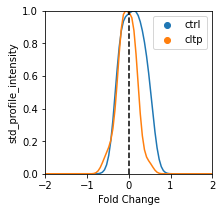

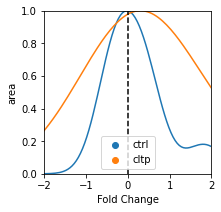

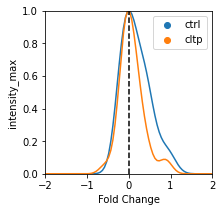

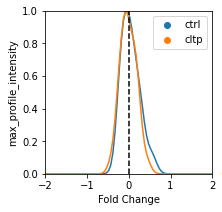

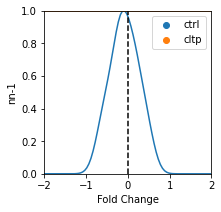

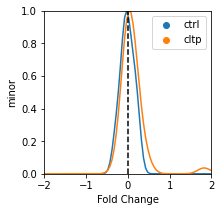

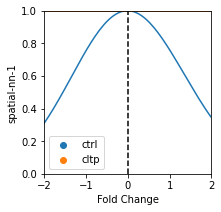

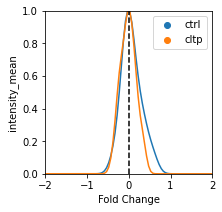

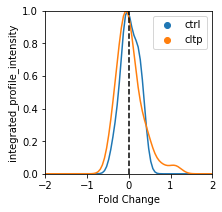

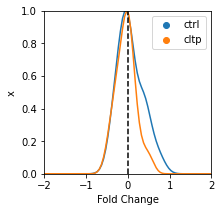

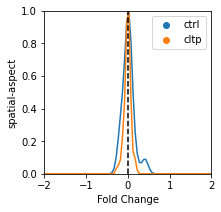

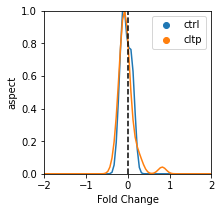

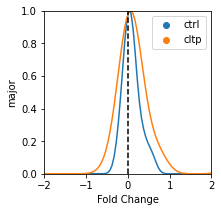

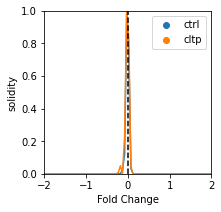

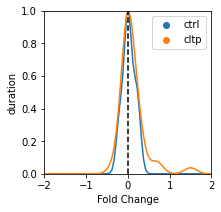

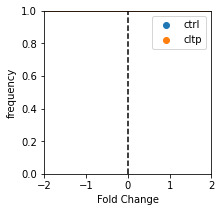

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


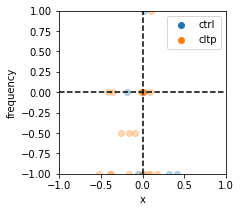

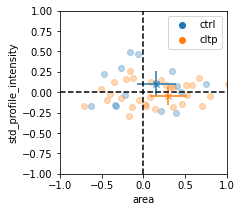

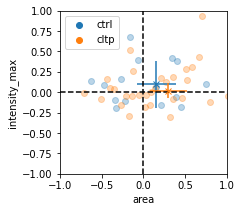

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


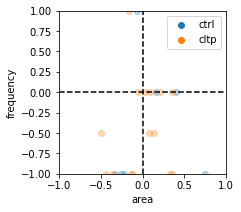

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


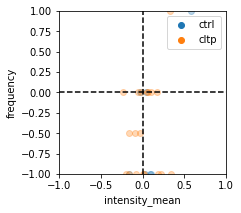

SIMILAR


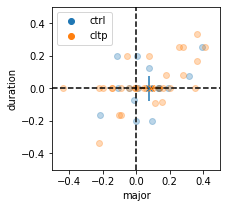

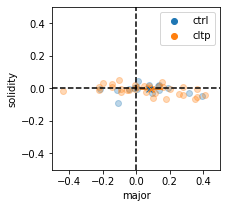

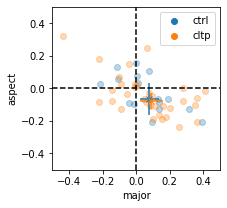

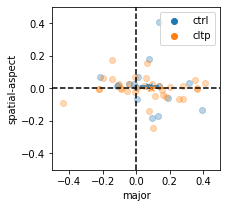

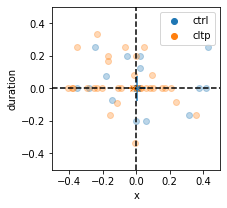

USER


divide by zero encountered in true_divide


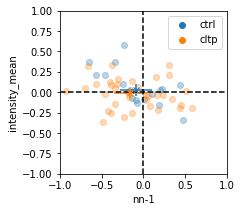

divide by zero encountered in true_divide


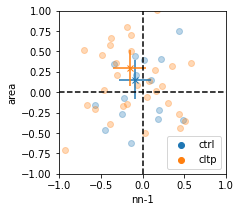

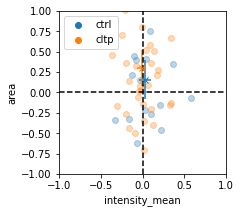

In [1139]:
def get_optimal(*features, return_independant=False):
    nums = defaultdict(list)
    for i, condition in enumerate(sorted(out.keys())):
        subdf = df[df.condition == condition]
        for unique in numpy.unique(subdf["image-id"]):
            subsubdf = subdf[subdf["image-id"] == unique]
            nums[condition].append([
                numpy.median(subsubdf[feature]) for feature in features
            ])

    means = []
    for i, (condition_a, condition_b) in enumerate([["/ctrl-baseline", "/ctrl-stim"], ["/cltp-baseline", "/cltp-stim"]]):
        values = (numpy.array(nums[condition_b]) - numpy.array(nums[condition_a])) / (numpy.array(nums[condition_a]))        
        means.append(numpy.median(values, axis=0))
    means = numpy.array(means)
    if return_independant:
        return numpy.sqrt(numpy.sum(means ** 2, axis=-1))
    else:
        return numpy.sqrt(numpy.sum(numpy.diff(means, axis=0) ** 2))

def plot_1d(feature_a):
    nums = defaultdict(list)
    for i, condition in enumerate(sorted(out.keys())):
        subdf = df[df.condition == condition]
        for unique in numpy.unique(subdf["image-id"]):
            subsubdf = subdf[subdf["image-id"] == unique]
            nums[condition].append([
                numpy.median(subsubdf[feature_a]),
            ])

    fig, ax = pyplot.subplots(figsize=(3, 3))
#     for i, (key, values) in enumerate(nums.items()):
    for i, (condition_a, condition_b) in enumerate([["/ctrl-baseline", "/ctrl-stim"], ["/cltp-baseline", "/cltp-stim"]]):
        values = (numpy.array(nums[condition_b]) - numpy.array(nums[condition_a])) / (numpy.array(nums[condition_a]) + 1e-6)        
        condition = condition_a.split("-")[0]

        kde = gaussian_kde(values.T)
        xs = numpy.linspace(-5, 5, 200)
        density = kde(xs[numpy.newaxis])
        density = density / density.max()
        ax.plot(xs, density)
        
#         bootstrapped = numpy.random.choice(len(values), size=(10000, len(values)))
#         bootstrapped = numpy.median(values[bootstrapped], axis=1)
#         err = numpy.diff(numpy.quantile(bootstrapped, [0.5, 0.95], axis=0), axis=0).ravel()
#         ax.errorbar(
#             *numpy.median(bootstrapped, axis=0), 
#             xerr=err[0], yerr=err[1],
#             marker="x", color=COLORS[condition])
        
    ax.legend(labels=["ctrl", "cltp"], handles=[pyplot.scatter([], [], color=c) for c in COLORS.values()])
    ax.set(
        xlabel="Fold Change", ylabel=feature_a
    )
    return fig, ax
    
def plot_2d(feature_a, feature_b):
    nums = defaultdict(list)
    for i, condition in enumerate(sorted(out.keys())):
        subdf = df[df.condition == condition]
        for unique in numpy.unique(subdf["image-id"]):
            subsubdf = subdf[subdf["image-id"] == unique]
            nums[condition].append([
                numpy.median(subsubdf[feature_a]),
                numpy.median(subsubdf[feature_b])
            ])

    fig, ax = pyplot.subplots(figsize=(3, 3))
#     for i, (key, values) in enumerate(nums.items()):
    for i, (condition_a, condition_b) in enumerate([["/ctrl-baseline", "/ctrl-stim"], ["/cltp-baseline", "/cltp-stim"]]):
        values = (numpy.array(nums[condition_b]) - numpy.array(nums[condition_a])) / (numpy.array(nums[condition_a]))        
        
        condition = condition_a.split("-")[0]
        ax.scatter(values[:, 0], values[:, 1], alpha=0.3, color=COLORS[condition])
        
        bootstrapped = numpy.random.choice(len(values), size=(10000, len(values)))
        bootstrapped = numpy.median(values[bootstrapped], axis=1)
        err = numpy.diff(numpy.quantile(bootstrapped, [0.5, 0.95], axis=0), axis=0).ravel()
        ax.errorbar(
            *numpy.median(bootstrapped, axis=0), 
            xerr=err[0], yerr=err[1],
            marker="x", color=COLORS[condition])
        
    ax.legend(labels=["ctrl", "cltp"], handles=[pyplot.scatter([], [], color=c) for c in COLORS.values()])
    ax.set(
        xlabel=feature_a, ylabel=feature_b
    )
    return fig, ax

import itertools
distances = {}
for key1 in df.keys()[5:]:
    distances[key1] = get_optimal(key1, return_independant=False)

for key, value in list(sorted(distances.items(), key=lambda kv: kv[1], reverse=True)):
    fig, ax = plot_1d(key)
    ax.axvline(0, color="black", linestyle="dashed")
    ax.set(
        ylim=(0, 1), xlim=(-2, 2)
    )
    savefig(fig, ax, f"./panels/population/kde-{key}", save_white=True)
    pyplot.show()

distances = {}
for key1, key2 in itertools.combinations(df.keys()[5:], r=2):
    distances["---".join((key1, key2))] = get_optimal(key1, key2)

for key, value in list(sorted(distances.items(), key=lambda kv: kv[1], reverse=True))[:5]:
    key1, key2 = key.split("---")
    
    fig, ax = plot_2d(key1, key2)
    ax.axhline(0, color="black", linestyle="dashed")
    ax.axvline(0, color="black", linestyle="dashed")    
    ax.set(
        ylim=(-1.0, 1.0), xlim=(-1.0, 1.0)
    )
    pyplot.show()
    
print("SIMILAR")
for key, value in list(sorted(distances.items(), key=lambda kv: kv[1]))[:5]:
    key1, key2 = key.split("---")
    
    fig, ax = plot_2d(key1, key2)
    ax.axhline(0, color="black", linestyle="dashed")
    ax.axvline(0, color="black", linestyle="dashed")    
    ax.set(
        ylim=(-0.5, 0.5), xlim=(-0.5, 0.5)
    )
    pyplot.show()    
    
print("USER")
for key1, key2 in [("nn-1", "intensity_mean"), ("nn-1", "area"), ("intensity_mean", "area")]:

    fig, ax = plot_2d(key1, key2)
    ax.axhline(0, color="black", linestyle="dashed")
    ax.axvline(0, color="black", linestyle="dashed")    
    ax.set(
        ylim=(-1.0, 1.0), xlim=(-1.0, 1.0)
    )
    pyplot.show()        

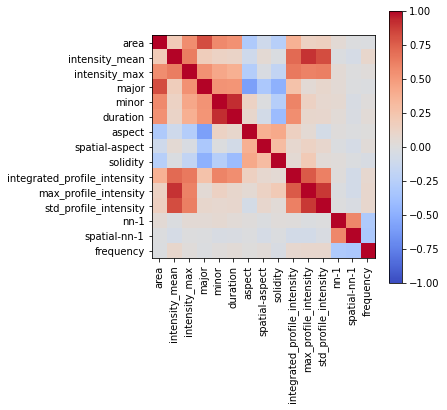

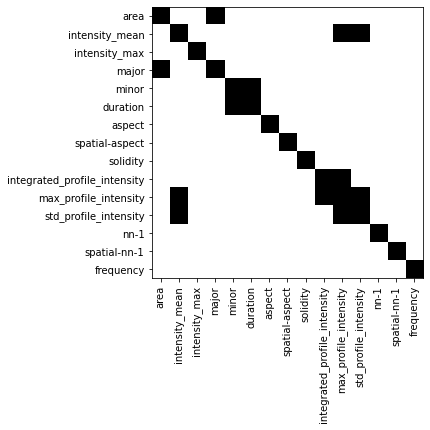

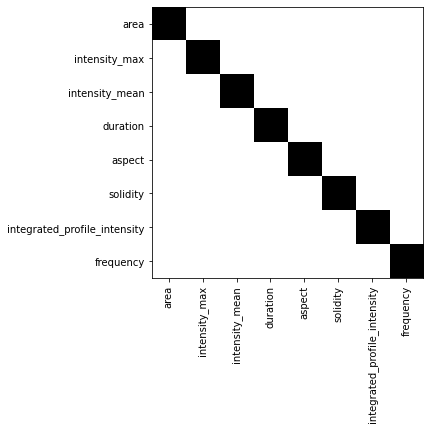

In [1375]:
# Validation of correlation between features
feature_df = df.iloc[:, 6:]
CLTP_MASK = df["condition"].str.contains("cltp")
feature_df = feature_df[CLTP_MASK]
keys = feature_df.keys()

correlation = feature_df.corr()
fig, ax = pyplot.subplots(figsize=(5, 5))
im = ax.imshow(correlation, cmap="coolwarm", vmin=-1, vmax=1)
ax.set(
    xticks=numpy.arange(len(keys)), yticks=numpy.arange(len(keys)),
    yticklabels=keys
)
ax.set_xticklabels(keys, rotation=90)
pyplot.colorbar(im, ax=ax)
pyplot.show()

fig, ax = pyplot.subplots(figsize=(5, 5))
ax.imshow(numpy.logical_or(correlation > 0.75, correlation < -0.75), cmap="Greys", vmin=0, vmax=1)
ax.set(
    xticks=numpy.arange(len(keys)), yticks=numpy.arange(len(keys)),
    yticklabels=keys
)
ax.set_xticklabels(keys, rotation=90)
pyplot.show()

KEEP_FEATURES = [
    "area", "intensity_max", "intensity_mean", "duration", "aspect", "solidity", "integrated_profile_intensity", "frequency",
]

feature_df = df.loc[:, KEEP_FEATURES]
keys = feature_df.keys()

correlation = feature_df.corr()
fig, ax = pyplot.subplots(figsize=(5, 5))
ax.imshow(numpy.logical_or(correlation > 0.75, correlation < -0.75), cmap="Greys", vmin=0, vmax=1)
ax.set(
    xticks=numpy.arange(len(keys)), yticks=numpy.arange(len(keys)),
    yticklabels=keys
)
ax.set_xticklabels(keys, rotation=90)
pyplot.show()

  0%|          | 0/18 [00:00<?, ?it/s]

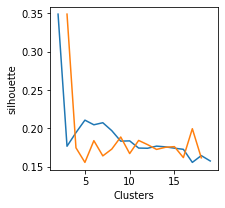

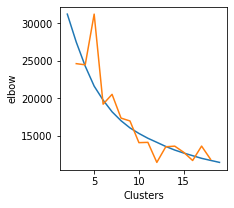

In [1376]:
feature_df = df.loc[CLTP_MASK, KEEP_FEATURES]
num_clusters = numpy.arange(2, 20)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(feature_df)
kmeanses, clusterers, scores = {}, [], defaultdict(list)
for nc in tqdm(num_clusters):
    clusterer = cluster.KMeans(n_clusters=nc, random_state=42)
#     clusterer = cluster.AgglomerativeClustering(n_clusters=nc, linkage="ward")
    kmeans = clusterer.fit(scaled_df)
    clusterers.append(clusterer)
    
    kmeanses[nc] = kmeans
    
    # Silhouette
    silscore = silhouette_score(scaled_df, kmeans.labels_)
    scores["silhouette"].append(silscore)
        
    # Elbow
    label = clusterer.labels_
    wss = []
    for unique in numpy.unique(label):
        # extract each cluster according to its index
        mask = label == unique
        features = scaled_df[mask]
        # calculate the WSS:
        features_mean = numpy.mean(features, axis=0)
        distances = numpy.sum(numpy.abs(features - features_mean)**2,axis=-1)
        wss.append(numpy.sum(distances))
    scores["elbow"].append(numpy.sum(wss))

for key, values in scores.items():
    fig, ax = pyplot.subplots(figsize=(3,3))
    values = numpy.array(values)
    ax.plot(num_clusters, values)
    diff = numpy.diff(values, 2)
    ax.plot(num_clusters[:-2] + 1, (diff - diff.min()) / (diff.max() - diff.min()) *  (values.max() - values.min()) + values.min())
    ax.set(
        ylabel=key, xlabel="Clusters"
    )
#     savefig(fig, ax, f"./panels/individual/{key}", save_white=True)
    pyplot.show()

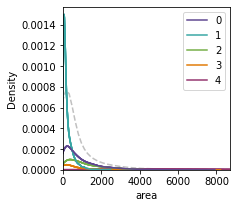

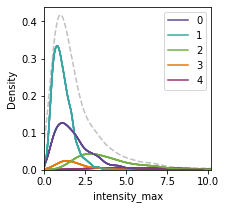

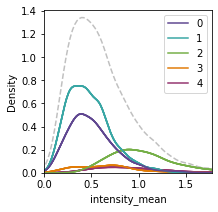

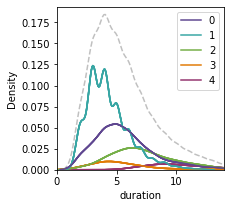

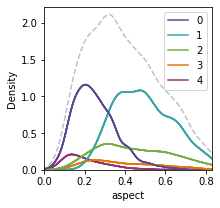

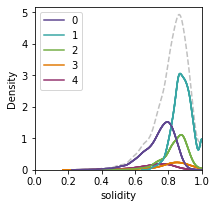

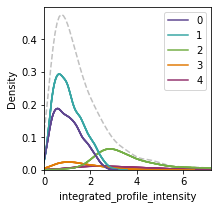

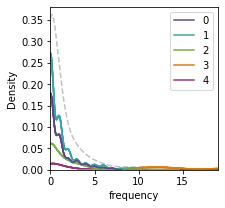

In [1377]:
CLUSTERS = 5 # CTRL: 6; cLTP: 5

features = list(feature_df.keys())

labels = kmeanses[CLUSTERS].labels_
for feature in features:
    fig, ax = pyplot.subplots(figsize=(3, 3), sharex=True, sharey=True)
    seaborn.kdeplot(data=feature_df, x=feature, ax=ax, cumulative=False, color="silver", linestyle="dashed")    
    for unique in numpy.unique(labels):
        seaborn.kdeplot(data=feature_df, x=feature, hue=labels, ax=ax, cumulative=False, palette="nice-prism")
    m, M = numpy.quantile(feature_df[feature], [0.01, 0.99])
    ax.set(
        xlim=(0, M)
    )
#     savefig(fig, ax, f"./panels/kdeplots/{feature}", save_white=True)
    pyplot.show()


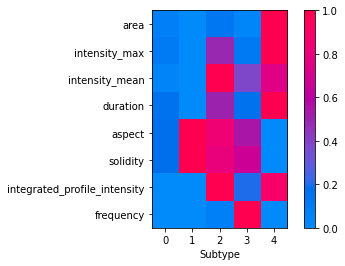

In [1378]:
from shap.plots.colors import red_blue
labels = kmeanses[CLUSTERS].labels_
avg_values = []
for unique in numpy.unique(labels):
    values = feature_df[labels == unique]
    avg_values.append(numpy.median(values, axis=0))

avg_values = numpy.array(avg_values)
m, M = numpy.min(avg_values, axis=0), numpy.max(avg_values, axis=0)
avg_values = (avg_values - m) / (M - m)

fig, ax = pyplot.subplots()
im = ax.imshow(avg_values.T, vmin=0, vmax=1, cmap=red_blue)
ax.set(
    yticks=numpy.arange(avg_values.shape[1]),
    yticklabels=features,
    xticks=numpy.arange(avg_values.shape[0]),
    xlabel="Subtype"
)
pyplot.colorbar(im, ax=ax)
# savefig(fig, ax, "./panels/individual/cluster-barcode", save_white=True)
pyplot.show()
#     m, M = numpy.quantile(feature_df[feature], [0.01, 0.99])
#     ax.set(
#         xlim=(0, M)
#     )
#     pyplot.show()   

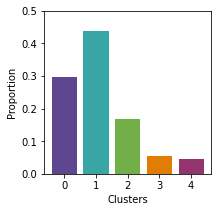

In [1267]:
labels = kmeanses[CLUSTERS].labels_
unique, num = numpy.unique(labels, return_counts=True)
density = num / num.sum()

fig, ax = pyplot.subplots(figsize=(3,3))
cmap = pyplot.get_cmap("nice-prism", len(density))
for u, n in zip(unique, density):
    ax.bar(u, n, color=cmap(u))
ax.set(
    xticks=numpy.arange(len(density)), xlabel="Clusters",
    ylabel="Proportion",
    ylim=(0, 0.5)
)
savefig(fig, ax, "./panels/individual/cluster-proportion", save_white=True)
pyplot.show()

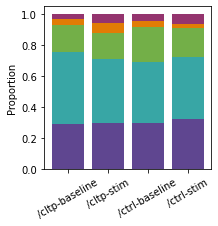

In [851]:
# We use the KNN on the entire array
labels = kmeanses[CLUSTERS].predict(scaler.transform(df.loc[:, KEEP_FEATURES]))

fig, ax = pyplot.subplots(figsize=(3, 3))
for i, condition in enumerate(df["condition"].unique()):
    mask = df.condition == condition
    nums = []
    for unique in numpy.unique(labels):
        other_mask = labels == unique
        nums.append(numpy.sum(mask * other_mask))
    cumsum = numpy.array(nums) / numpy.sum(nums)
#     cumsum = cumsum / numpy.max(cumsum)
    cmap = pyplot.get_cmap("nice-prism", len(cumsum))
    for j in range(0, len(cumsum)):
        ax.bar(i, cumsum[j], bottom=numpy.sum(cumsum[:j]), color=cmap(j))

ax.set(
    xticks=numpy.arange(len(out)), ylabel="Proportion"
)
ax.set_xticklabels(sorted(out.keys()), rotation=30)
pyplot.show()

[ 0.24928681  0.04463418 -0.50354879 -1.86307296  1.17197412]
[0.40156947 0.48219945 0.30728924 0.031226   0.12060372]


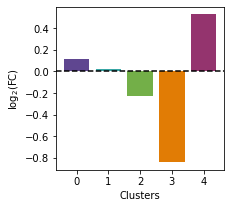

[ 0.08168365 -0.35543772 -0.23619042  2.13999987  1.46574148]
[0.46744914 0.36113085 0.40664245 0.01617739 0.07135937]


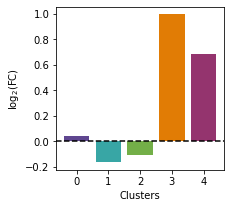

In [852]:
for i, (condition_a, condition_b) in enumerate([["/ctrl-baseline", "/ctrl-stim"], ["/cltp-baseline", "/cltp-stim"]]):
    mask = df.condition == condition_a
    nums = []
    for unique in numpy.unique(labels):
        other_mask = labels == unique
        nums.append(numpy.sum(mask * other_mask))
    cumsum_a = numpy.array(nums) / numpy.sum(nums)
    
    mask = df.condition == condition_b
    nums = []
    for unique in numpy.unique(labels):
        other_mask = labels == unique
        nums.append(numpy.sum(mask * other_mask))
    cumsum_b = numpy.array(nums) / numpy.sum(nums)
    
    differential = (cumsum_b - cumsum_a) / cumsum_a
    differential = cumsum_b / cumsum_a
    differential = numpy.log2(differential) - numpy.log2(numpy.sum(cumsum_b) / numpy.sum(cumsum_a))
    std = numpy.std(differential)
    z_score = differential / std
    print(z_score)
    p_values = 1 - stats.norm.cdf(abs(z_score))
    print(p_values)
    
    fig, ax = pyplot.subplots(figsize=(3, 3))
    cmap = pyplot.get_cmap("nice-prism", len(differential))
    for j in range(0, len(differential)):
        ax.bar(j, differential[j], color=cmap(j))
    ax.axhline(y=0, linestyle="dashed", color="black")
    ax.set(
        ylabel=r"$\log_{2}({\rm FC})$", 
#         ylim=(-0.2, 0.5),
        xlabel="Clusters", xticks=numpy.arange(len(differential)),
#         title=f"{condition_a} - {condition_b}"
    )
    name = condition_a.split("-")[0].split("/")[-1]
#     savefig(fig, ax, f"./panels/individual/cluster-number-fold-change_{name}", save_white=True)
    pyplot.show()


In [1268]:
# Obtain clusters
feature_df = df.loc[CLTP_MASK, KEEP_FEATURES]
scaled_df = scaler.fit_transform(feature_df)

cluster_values = []
uniques = numpy.unique(labels)
for unique in uniques:
    values = scaled_df[labels == unique]
    cluster_values.append(numpy.median(values, axis=0))
cluster_values = numpy.array(cluster_values)

keep = 5
DELTA_t, DELTA_xy = 0, 32
distances = distance.cdist(scaled_df, cluster_values)
argsorted = numpy.argsort(distances, axis=0)

import shutil
if os.path.isdir("./panels/individual/examples"):
    shutil.rmtree("./panels/individual/examples")
os.makedirs("./panels/individual/examples", exist_ok=True)
for cluster_idx in tqdm(uniques):
    items = df.iloc[argsorted[:, cluster_idx]]
    num = 0
    for idx, item in items.iterrows():
        movie_file = item["image-id"]
        stream = preprocess_stream(tifffile.imread(movie_file))
        prediction = tifffile.imread(movie_file.replace("experiments", f"experiments/Analysis/{MODEL_NAME}").replace(".tif", "_prediction.tif"))
        prediction = prediction > THRESHOLD
        prediction = measure.label(prediction)
        
        t, y, x = map(int, (item["t"], item["y"], item["x"]))
        if (t > DELTA_t) and (t < stream.shape[0] - DELTA_t) and \
            (y > DELTA_xy) and (y < stream.shape[1] - DELTA_xy) and \
            (x > DELTA_xy) and (x < stream.shape[2] - DELTA_xy):
            
            num += 1
            
            crop = stream[
                t - DELTA_t : t + DELTA_t + 1, y - DELTA_xy : y + DELTA_xy, x - DELTA_xy : x + DELTA_xy
            ]
            max_proj = numpy.max(crop, axis=0)
            
            crop_pred = prediction[
                t - DELTA_t : t + DELTA_t + 1, y - DELTA_xy : y + DELTA_xy, x - DELTA_xy : x + DELTA_xy
            ]
            max_proj_crop = numpy.max(crop_pred>0, axis=0)
            
            crop_pred_event_only = crop_pred == prediction[t, y, x]
            max_proj_crop_event_only = numpy.max(crop_pred_event_only, axis=0)

#             fig, axes = pyplot.subplots(1, 2)
#             axes[0].imshow(max_proj, cmap="gray")
#             axes[1].imshow(max_proj_crop, cmap="gray")            
#             pyplot.show()
#             break
            
            tifffile.imwrite(
                f"./panels/individual/examples/{cluster_idx}-{idx}_max-proj.tif", 
                max_proj.astype(numpy.float32)
            )        
            tifffile.imwrite(
                f"./panels/individual/examples/{cluster_idx}-{idx}_max-proj-pred.tif", 
                max_proj_crop.astype(numpy.uint8)
            )
            tifffile.imwrite(
                f"./panels/individual/examples/{cluster_idx}-{idx}_max-proj-pred_event-only.tif", 
                max_proj_crop_event_only.astype(numpy.uint8)
            )            

            if num >= keep - 1:
                break

  0%|          | 0/5 [00:00<?, ?it/s]

In [768]:
phate_operator = phate.PHATE(n_jobs=-2)
X_transformed = phate_operator.fit_transform(scaled_df)

Calculating PHATE...
  Running PHATE on 7385 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.26 seconds.
    Calculating KMeans...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f9554517e50>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/calcium/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/anaconda3/envs/calcium/lib/python3.8/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/opt/anaconda3/envs/calcium/lib/python3.8/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/anaconda3/envs/calcium/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


    Calculated KMeans in 2.22 seconds.
  Calculated landmark operator in 3.17 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 1.78 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.35 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.59 seconds.
Calculated PHATE in 9.21 seconds.


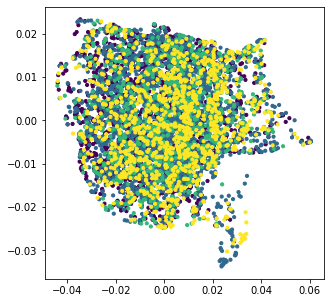

/cltp-baseline


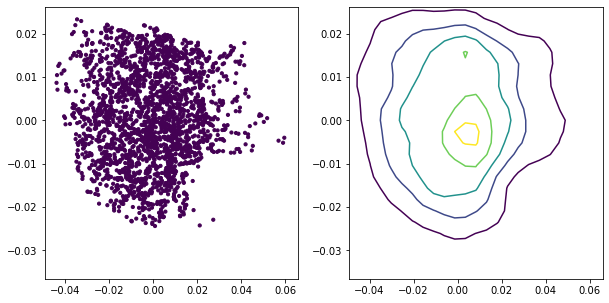

/cltp-stim


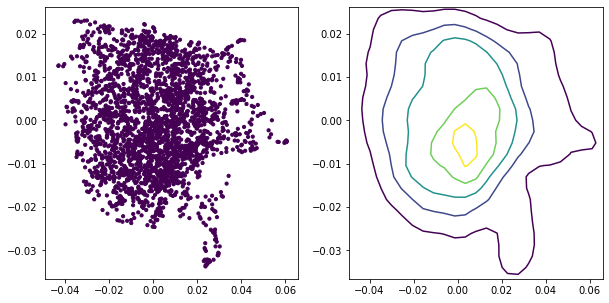

/ctrl-baseline


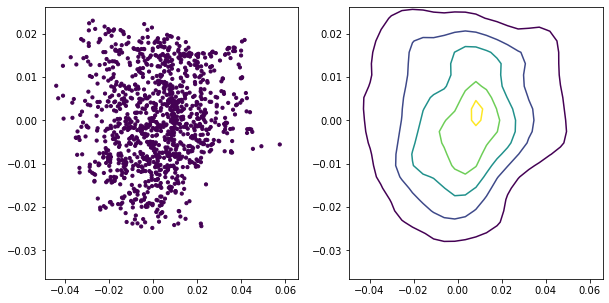

/ctrl-stim


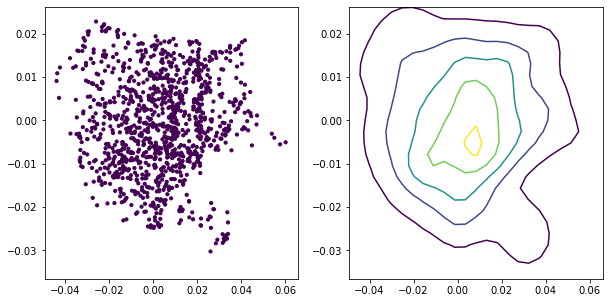

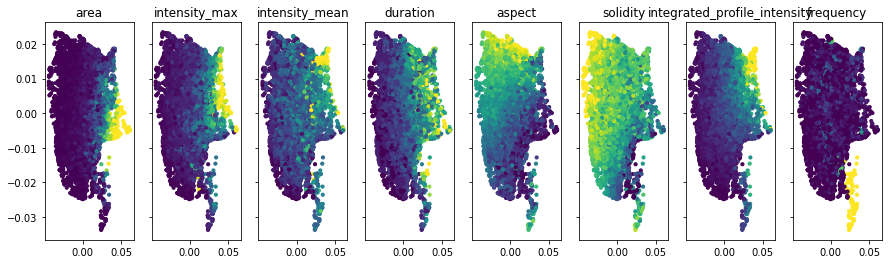

In [793]:

uniques = df.condition.unique().tolist()

fig, ax = pyplot.subplots(figsize=(5, 5))
color = numpy.array([uniques.index(condition) for condition in df["condition"]])
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, alpha=1.0, s=10)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
pyplot.show()

for condition in uniques:
    print(condition)
    mask = df.condition == condition
    
    fig, axes = pyplot.subplots(1, 2, figsize=(10, 5))
    ax.set(
        title=condition
    )
    color = numpy.array([uniques.index(condition) for condition in df["condition"]])[mask]
    axes[0].scatter(X_transformed[mask, 0], X_transformed[mask, 1], c=color, alpha=1.0, s=10)
    axes[0].set(
        xlim=xlim, ylim=ylim
    )
    
    YY, XX = numpy.meshgrid(
        numpy.linspace(*ylim, 25), 
        numpy.linspace(*xlim, 25))
    kde = gaussian_kde(X_transformed[mask].T)
    ZZ = kde(numpy.stack((XX.ravel(), YY.ravel()))).reshape(XX.shape)
    ZZ = ZZ / ZZ.sum()
#     ZZ = (ZZ - ZZ.min()) / (ZZ.max() - ZZ.min())
    axes[1].contour(
        XX, YY, ZZ, levels=[0.05 * ZZ.max(), 0.25 * ZZ.max(), 0.5 * ZZ.max(), 0.75 * ZZ.max(), 0.95 * ZZ.max()], 
    )
    axes[1].set(
        xlim=xlim, ylim=ylim
    )
    pyplot.show()
    
fig, axes = pyplot.subplots(1, len(features), figsize=(15, 4), sharex=True, sharey=True)
for ax, feature in zip(axes.ravel(), features):
    color = scaled_df[:, features.index(feature)]
    m, M = numpy.quantile(color, [0.01, 0.99])
    ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, vmin=m, vmax=M, alpha=1.0, s=10)
    ax.set(
        title=feature
    )
pyplot.show()   

# Per Movie

Condition: /ctrl ---- Removed: 0
Condition: /cltp ---- Removed: 2


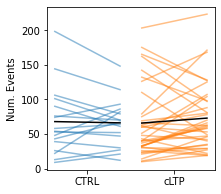

The standardize residuals are not normaly distributed.
The null hypothesis cannot be rejected from the Kruskal-Wallis H-test.
	pvalue : 0.7039860148102106


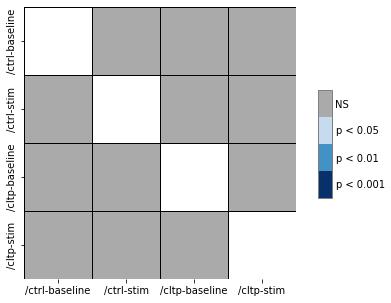

Num. Streams :  17
WilcoxonResult(statistic=66.0, pvalue=0.644134521484375)
Num. Streams :  36
WilcoxonResult(statistic=166.0, pvalue=0.008696836922605977)


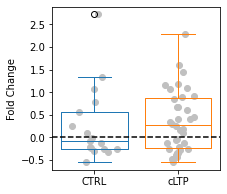

In [1379]:
MINIMUM_EVENTS = 5
SPACE = 0.75
cmap = pyplot.get_cmap("tab10")
KEEP_NEURON = {}

fig, ax = pyplot.subplots(figsize=(3, 3))
samples, labels_, fold_change = [], [], []
for i, (condition_a, condition_b) in enumerate([["/ctrl-baseline", "/ctrl-stim"], ["/cltp-baseline", "/cltp-stim"]]):
    cumsum_a = {}
    condition_mask = df.condition == condition_a
    for image_id in df["image-id"][condition_mask].unique():
        neuron_id = int(image_id.split("/")[-1].split("-")[0])
        image_mask = df["image-id"] == image_id
        cumsum_a[neuron_id] = numpy.sum(condition_mask * image_mask)

    cumsum_b = {}
    condition_mask = df.condition == condition_b
    for image_id in df["image-id"][condition_mask].unique():
        neuron_id = int(image_id.split("/")[-1].split("-")[0])        
        image_mask = df["image-id"] == image_id
        cumsum_b[neuron_id] = numpy.sum(condition_mask * image_mask)
    
    order = numpy.array(sorted(cumsum_a.keys()))
    cumsum_a = numpy.array([
        cumsum_a[key] for key in order
    ]).squeeze()
    cumsum_b = numpy.array([
        cumsum_b[key] for key in order
    ]).squeeze()
    
    keep_mask = numpy.logical_and(cumsum_a >= MINIMUM_EVENTS, cumsum_b >= MINIMUM_EVENTS)
    print("Condition: {} ---- Removed: {}".format(condition_a.split("-")[0], numpy.sum(keep_mask == False)))
                
    KEEP_NEURON[condition_a] = order[keep_mask]
    KEEP_NEURON[condition_b] = order[keep_mask]
    
    cumsum_a, cumsum_b = cumsum_a[keep_mask], cumsum_b[keep_mask]
    
    samples.append(cumsum_a)
    samples.append(cumsum_b)
    labels_.append(condition_a)
    labels_.append(condition_b)
    fold_change.append((cumsum_b - cumsum_a) / cumsum_a)
    
    for a, b in zip(cumsum_a, cumsum_b):
        ax.plot(
            [i, i + SPACE], [a, b], color=cmap(i), alpha=0.5
        )
    ax.plot(
        [i, i + SPACE], [numpy.mean(cumsum_a), numpy.mean(cumsum_b)], color="black"
    )
    
ax.set(
    ylabel="Num. Events", 
    xticks=numpy.arange(2) + SPACE / 2, xticklabels=["CTRL", "cLTP"]
)
# savefig(fig, ax, f"./panels/per-movie/raw_ctrl-cltp_before-after", save_white=True)
pyplot.show()

_, p_values = get_significance(samples, labels_, show_qq=False, show_sr=False, verbose=True)
fig, ax = plot_pvalues(p_values)
pyplot.show()

fig, ax = pyplot.subplots(figsize=(3,3))
for i, fc in enumerate(fold_change):
    bplot = ax.boxplot(fc, positions=[i], widths=0.8)
    xs = numpy.random.normal(loc=i, scale=0.1, size=len(fc))
    ax.scatter(xs, fc, color="silver")
    for part, items in bplot.items():
        for item in items:
            item.set_color(cmap(i))
ax.axhline(y=0, linestyle="dashed", color="black")
ax.set(
    ylabel="Fold Change", 
    xticks=numpy.arange(2), xticklabels=["CTRL", "cLTP"]
)
# savefig(fig, ax, f"./panels/per-movie/fc_ctrl-cltp_before-after", save_white=True)

fitted, residuals, standard_res, quantiles = fit_model(fold_change)
normalities = verify_normality(standard_res)
for differences in fold_change:
    print("Num. Streams : ", len(differences))
    print(stats.wilcoxon(differences))
pyplot.show()

[0.30380355 0.41388855 0.19844563 0.03094495 0.05291732]


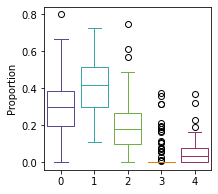

In [1380]:
CLUSTERS = 5 # CTRL: 6; cLTP: 5
# We use the KNN on the entire array
labels = kmeanses[CLUSTERS].predict(scaler.transform(df.loc[:, KEEP_FEATURES]))

densities = []
for image_id in df["image-id"].unique():
    mask = df["image-id"] == image_id
    neuron_id = df["neuron-id"][mask].iloc[0]
    condition_id = "/" + image_id.split("/")[-2]
    
    if neuron_id in KEEP_NEURON[condition_id]:
        unique, num = numpy.unique(labels[mask], return_counts=True)
        nums = numpy.zeros(CLUSTERS)
        nums[unique] = num
        densities.append(nums / numpy.sum(nums))

densities = numpy.array(densities)
print(numpy.mean(densities, axis=0))

fig, ax = pyplot.subplots(figsize=(3,3))
cmap = pyplot.get_cmap("nice-prism", densities.shape[-1])
for u, samples in enumerate(densities.T):
    bplot=ax.boxplot(samples, positions=[u], widths=0.8)
    for item, parts in bplot.items():
        for part in parts:
            part.set_color(cmap(u))
ax.set(
#     xticks=numpy.arange(densities.shape[-1]), xlabel="Clusters",
    ylabel="Proportion"
)
pyplot.show()

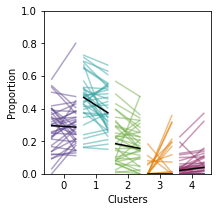

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 1.297810637443232e-46
Posthoc Dunn is computed on the data.
Posthoc Dunn results
	pvalues :               1             2             3             4             5   \
1   1.000000e+00  7.354759e-01  4.445800e-03  3.434648e-02  1.204025e-01   
2   7.354759e-01  1.000000e+00  1.218242e-02  7.538251e-02  5.863280e-02   
3   4.445800e-03  1.218242e-02  1.000000e+00  4.661939e-01  1.093777e-05   
4   3.434648e-02  7.538251e-02  4.661939e-01  1.000000e+00  2.434376e-04   
5   1.204025e-01  5.863280e-02  1.093777e-05  2.434376e-04  1.000000e+00   
6   3.458950e-02  1.424670e-02  7.129670e-07  2.346155e-05  5.754485e-01   
7   1.532789e-13  1.143999e-14  1.471093e-24  2.093632e-21  5.503176e-09   
8   9.523376e-10  1.081828e-10  3.192291e-19  1.823073e-16  5.016086e-06   
9   5.578848e-09  6.970049e-10  4.187339e-18  1.943528e-15  1.904265e-05   
10  2.191995e-0

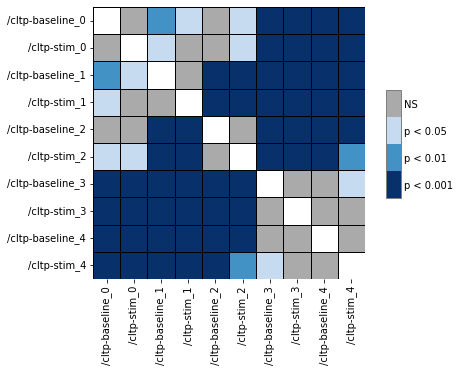

In [1381]:

samples, labels_, fold_change = [], [], []
for i, (condition_a, condition_b) in enumerate([["/cltp-baseline", "/cltp-stim"]]):
    cumsum_a = defaultdict(list)
    condition_mask = df.condition == condition_a
    for image_id in df["image-id"][condition_mask].unique():
        neuron_id = int(image_id.split("/")[-1].split("-")[0])
        if neuron_id in KEEP_NEURON[condition_a]:
            image_mask = df["image-id"] == image_id
            nums = []
            for unique in numpy.unique(labels):
                label_mask = labels == unique
                nums.append(numpy.sum(condition_mask * label_mask * image_mask))
            cumsum_a[neuron_id].append(numpy.array(nums) / numpy.sum(nums))

    cumsum_b = defaultdict(list)
    condition_mask = df.condition == condition_b
    for image_id in df["image-id"][condition_mask].unique():
        neuron_id = int(image_id.split("/")[-1].split("-")[0])  
        if neuron_id in KEEP_NEURON[condition_b]:
            image_mask = df["image-id"] == image_id
            nums = []
            for unique in numpy.unique(labels):
                label_mask = labels == unique
                nums.append(numpy.sum(condition_mask * label_mask * image_mask))
            cumsum_b[neuron_id].append(numpy.array(nums) / numpy.sum(nums))
    
    order = list(sorted(cumsum_a.keys()))
    cumsum_a = numpy.array([
        cumsum_a[key] for key in order
    ]).squeeze()
    cumsum_b = numpy.array([
        cumsum_b[key] for key in order
    ]).squeeze()

    fig, ax = pyplot.subplots(figsize=(3, 3))
    cmap = pyplot.get_cmap("nice-prism", cumsum_a.shape[-1])
    for image_id, (a, b) in enumerate(zip(cumsum_a, cumsum_b)):
        for unique in numpy.unique(labels):
            ax.plot([unique, unique + SPACE], [a[unique], b[unique]], color=cmap(unique), alpha=0.5)
    for unique in numpy.unique(labels):
        ax.plot([unique, unique + SPACE], 
                [numpy.median(cumsum_a[:, unique]), numpy.median(cumsum_b[:, unique])], color="black")
    ax.set(
        ylabel="Proportion",
        ylim=(0, 1),
        xlabel="Clusters", 
        xticks=numpy.arange(cumsum_a.shape[-1]) + SPACE / 2,
        xticklabels=numpy.unique(labels)
#         title=f"{condition_a} - {condition_b}"
    )
    name = condition_a.split("-")[0].split("/")[-1]
#     savefig(fig, ax, f"./panels/individual/cluster-number-fold-change_{name}", save_white=True)
#     savefig(fig, ax, f"./panels/per-movie/prop_cltp_before-after", save_white=True)
    pyplot.show()
    
    # Statistics
    for unique in numpy.unique(labels):
        samples.append(cumsum_a[:, unique])
        labels_.append(f"{condition_a}_{unique}")
        samples.append(cumsum_b[:, unique])
        labels_.append(f"{condition_b}_{unique}")
        
        mask = numpy.logical_and(
            cumsum_a[:, unique] > 0, cumsum_b[:, unique] > 0
        )
        fold_change.append((cumsum_b[mask, unique]-cumsum_a[mask, unique]) / cumsum_a[mask, unique])

tmp = sorted(zip(labels_, samples), key=lambda x: int(x[0].split("_")[-1]))
labels_, samples = zip(*tmp)
labels_, samples = list(labels_), list(samples)

significance, pvalues = get_significance(samples, labels=labels_, show_qq=False, show_sr=False, verbose=True)
fig, ax = plot_pvalues(pvalues)
pyplot.show()

# significance, pvalues = get_significance(fold_change, labels=labels_, show_qq=False, show_sr=False, verbose=False)
# fig, ax = plot_pvalues(pvalues)
# pyplot.show()

## Event type

In [1382]:
# Event type
# Recurrent, appear, vanish
while "event-type" in df.keys():
    df.drop(columns="event-type", inplace=True)
df.insert(0, "event-type", -1, allow_duplicates=False)

condition = "/cltp-baseline"
for neuron_id in KEEP_NEURON[condition]:
    sub_df = df[df["neuron-id"] == neuron_id]
    conditions = sub_df["condition"].unique()
    coords = {}
    for condition in conditions:
        mask = sub_df["condition"] == condition
        coords[condition] = numpy.stack([
            sub_df["y"][mask], sub_df["x"][mask]
        ]).T
    if coords:
        distances = distance.cdist(coords[conditions[0]], coords[conditions[1]])
        associated = distances < 6
        
        recurrent_before_events = numpy.any(associated, axis=1)
        vanish_events = numpy.all(~associated, axis=1)
        recurrent_after_events = numpy.any(associated, axis=0)
        appear_events = numpy.all(~associated, axis=0)
        
        mask = sub_df[sub_df["condition"] == conditions[0]]
        df.loc[mask.index, "event-type"] = [
            "recurrent-before" if r else "silenced" for r in recurrent_before_events
#             "recurrent" if r else "silenced" for r in recurrent_before_events            
        ]
        mask = sub_df[sub_df["condition"] == conditions[1]]
        df.loc[mask.index, "event-type"] = [
            "recurrent-after" if r else "new" for r in recurrent_after_events
#             "recurrent" if r else "new" for r in recurrent_after_events            
        ]

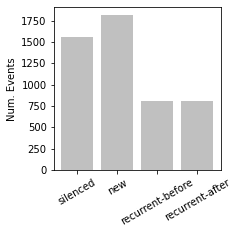

In [1383]:
cmap = pyplot.get_cmap("RdPu", 4 + 1)
event_types = {
    "silenced" : ["/cltp-baseline"], 
    "new" : ["/cltp-stim"], 
    "recurrent-before" : ["/cltp-baseline"],
    "recurrent-after" : ["/cltp-stim"],
    "recurrent" : ["/ctrl-stim", "/cltp-stim"]
}

fig, ax = pyplot.subplots(figsize=(3,3))
labels_ = []
for i, (event_type, conditions) in enumerate(event_types.items()):
    event_mask = df["event-type"] == event_type
    if not any(event_mask):
        continue
            
    mask = event_mask
    ax.bar(i, numpy.sum(mask), color="silver")
    labels_.append(event_type)

ax.set(
    ylabel="Num. Events",
    xticks = numpy.arange(len(labels_))
)
ax.set_xticklabels(labels_, rotation=30)
# savefig(fig, ax, f"./panels/per-event-type/raw_cltp_total", save_white=True)
pyplot.show()

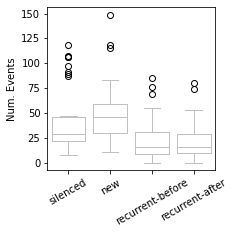

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 1.1837826667296217e-07
Posthoc Dunn is computed on the data.
Posthoc Dunn results
	pvalues :           1         2         3         4
1  1.000000  0.183652  0.000526  0.000775
2  0.183652  1.000000  0.000002  0.000003
3  0.000526  0.000002  1.000000  0.915605
4  0.000775  0.000003  0.915605  1.000000


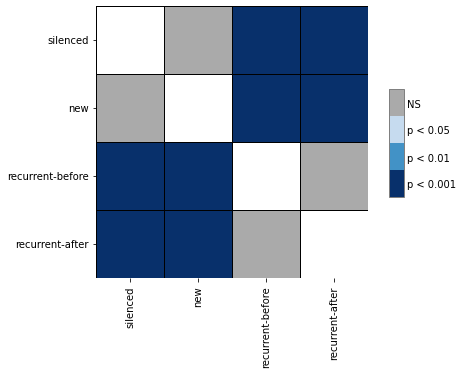

[ 42  23  22   8 106  26  22  23  18  22 106  97 118  44  21  89 107  11
  91  41   8  18  42  19  20  24  87  20  22  23  36  46  47  40  31  43] [ 34  81  51  40  83  41  19  15  19  56  53  73 149  48  59  48  61  27
 115  51  17  49  38  33  59  37  30  30  13  44 118  44  66  76  11  27]
[-0.19047619  2.52173913  1.31818182  4.         -0.21698113  0.57692308
 -0.13636364 -0.34782609  0.05555556  1.54545455 -0.5        -0.24742268
  0.26271186  0.09090909  1.80952381 -0.46067416 -0.42990654  1.45454545
  0.26373626  0.24390244  1.125       1.72222222 -0.0952381   0.73684211
  1.95        0.54166667 -0.65517241  0.5        -0.40909091  0.91304348
  2.27777778 -0.04347826  0.40425532  0.9        -0.64516129 -0.37209302]
[False]
WilcoxonResult(statistic=168.5, pvalue=0.016413682881857856)
[ 6 17 11  6 69 14  8  5 11 36 35 85 25 30 76 55 35 19 14 18 12 16 23  9
 14 43 20 16 35 12 19] [ 8 23 10  6 44 17 10 10  7 28 25 74 32 48 80 36 53 27 17 15 11 10 19  7
 15 53 18 22 49 11 13]
[ 0.33

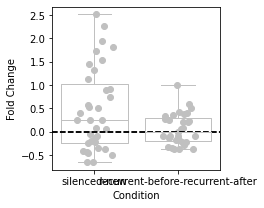

In [1406]:
fig, ax = pyplot.subplots(figsize=(3,3))
samples, labels_ = [], []
for i, (event_type, conditions) in enumerate(event_types.items()):
    event_mask = df["event-type"] == event_type
    if not any(event_mask):
        continue

    per_neuron = []    
    for condition in conditions:
        
        condition_mask = df["condition"] == condition
        mask = condition_mask * event_mask
        for neuron_id in KEEP_NEURON[condition]:
            condition_mask = df["condition"] == condition
            event_mask = df["event-type"] == event_type
            neuron_mask = df["neuron-id"] == neuron_id
            
            per_neuron.append(numpy.sum(condition_mask * event_mask * neuron_mask))
            
#     mask = event_mask
    bplot = ax.boxplot(per_neuron, positions=[i], widths=0.8)
    for key, items in bplot.items():
        for item in items:
            item.set_color("silver")

    samples.append(per_neuron)
    labels_.append(event_type)
ax.set(
    ylabel="Num. Events",
    xticks = numpy.arange(len(labels_)), xticklabels=labels_
)
ax.set_xticklabels(labels_, rotation=30)
# savefig(fig, ax, f"./panels/per-event-type/raw_cltp_per-movie", save_white=True)
pyplot.show()

_, pvalues = get_significance(samples, labels_, verbose=True)
fig, ax = plot_pvalues(pvalues)
pyplot.show()

# Measure FC between videos
conditions = [
    ["silenced", "new"], # silenced vs. new
    ["recurrent-before", "recurrent-after"], # recurrent vs. recurrent
]
fig, ax = pyplot.subplots(figsize=(3,3))
for i, (condition_a, condition_b) in enumerate(conditions):
    sample_a, sample_b = samples[labels_.index(condition_a)], samples[labels_.index(condition_b)]
    sample_a, sample_b = map(numpy.array, [sample_a, sample_b])
    
    # Only keep videos with at least 5 events
    mask = numpy.logical_and(sample_a >= 5, sample_b >= 5)
    fold_change = (sample_b[mask] - sample_a[mask]) / (sample_a[mask])
    print(sample_a[mask], sample_b[mask])
    print(fold_change)
    
    # Remove outliers
    q1, q3 = numpy.quantile(fold_change, [0.25, 0.75])
    iqr = q3 - q1
    mask = numpy.logical_and(fold_change > q1 - 1.5 * iqr, fold_change < q3 + 1.5 * iqr)
    fold_change = fold_change[mask]
    
    bplot = ax.boxplot(fold_change, positions=[i], widths=0.8)
    xs = numpy.random.normal(loc=i, scale=0.1, size=len(fold_change))
    ax.scatter(xs, fold_change, color="silver")
    for key, items in bplot.items():
        for item in items:
            item.set_color("silver")
    ax.axhline(y=0, color="black", linestyle="dashed")
    
    fitted, residuals, standard_res, quantiles = fit_model([fold_change])
    normalities = verify_normality([standard_res])
    print(normalities)
    if all(normalities):
        print(stats.ttest_1samp(fold_change, 0))
    else:
        print(stats.wilcoxon(fold_change))
#     savefig(fig, ax, "./panels/per-event-type/fc_cltp_per-movie_{}-{}".format(condition_a, condition_b), save_white=True)
ax.set(
    ylabel="Fold Change", xticklabels=["-".join((ca, cb)) for ca, cb in conditions],
    xlabel="Condition"
)
pyplot.show()        

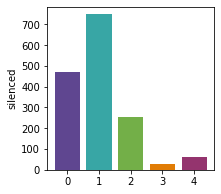

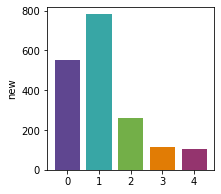

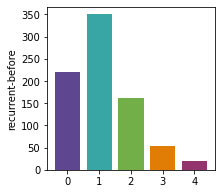

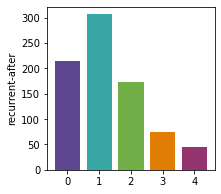

In [1388]:
cmap = pyplot.get_cmap("nice-prism", CLUSTERS)
event_types = {
    "silenced" : ["/cltp-baseline"], 
    "new" : ["/cltp-stim"], 
    "recurrent-before" : ["/cltp-baseline"],
    "recurrent-after" : ["/cltp-stim"],
    "recurrent" : ["/ctrl-stim", "/cltp-stim"],
}

for event_type, conditions in event_types.items():
    event_mask = df["event-type"] == event_type
    if not any(event_mask):
        continue
            
    mask = event_mask
    proportion = numpy.zeros(CLUSTERS)
    unique, counts = numpy.unique(labels[mask], return_counts=True)
    proportion[unique] = counts# / numpy.sum(counts)   
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.bar(numpy.arange(CLUSTERS), proportion, color=[cmap(i) for i in range(CLUSTERS)])
    ax.set(
#         ylim=(0, 1), 
        ylabel=event_type,
        xticks = numpy.arange(CLUSTERS), xticklabels=numpy.arange(CLUSTERS)
    )
    pyplot.show()

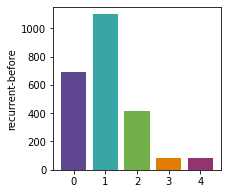

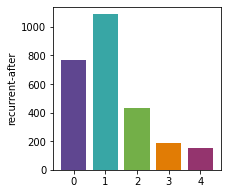

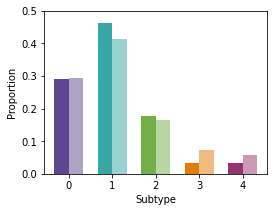

5.413125503395122e-11
[9.50158908e-01 4.70612720e-04 2.63176987e-01 5.88117433e-09
 1.28120752e-04]
[False  True False  True  True]


In [1389]:
cmap = pyplot.get_cmap("nice-prism", CLUSTERS)
before_after = {
    "before" : ["silenced", "recurrent-before"],
    "after" : ["new", "recurrent-after"],    
}

samples, samples_norm, labels_ = [], [], []
for key, events in before_after.items():
    event_mask = df["event-type"] == events[0]
    for event_type in events[1:]:
        event_mask += df["event-type"] == event_type
    if not any(event_mask):
        continue
            
    mask = event_mask
    proportion = numpy.zeros(CLUSTERS)
    unique, counts = numpy.unique(labels[mask], return_counts=True)
    proportion[unique] = counts# / numpy.sum(counts)   
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.bar(numpy.arange(CLUSTERS), proportion, color=[cmap(i) for i in range(CLUSTERS)])
    ax.set(
#         ylim=(0, 1), 
        ylabel=event_type,
        xticks = numpy.arange(CLUSTERS), xticklabels=numpy.arange(CLUSTERS)
    )
    pyplot.show()
    
    samples.append(proportion)
    samples_norm.append(proportion / numpy.sum(counts))
    labels_.append(key)

fig, ax = pyplot.subplots(figsize=(4,3))
widths = 1 / (len(samples_norm) + 1)
for n, observations in enumerate(samples_norm):
    for i, obs in enumerate(observations):
        ax.bar(i + (n * widths), obs, color=cmap(i), width=widths, alpha=1 - (n / len(samples_norm)))
ax.set(
    ylim=(0, 0.5), ylabel="Proportion",
    xlabel="Subtype", xticks=numpy.arange(CLUSTERS) + widths / len(labels_to_compare),
    xticklabels=numpy.arange(CLUSTERS)
)    
# savefig(fig, ax, "./panels/per-event-type/proportion_cltp_subtype-distribution_before-after", save_white=True)    
pyplot.show()
    
chi2, pvalue = chi2_stats(*samples)
print(pvalue)
if pvalue < 0.05:
    # Post-Hoc; Compare between bins
    pvalues = []
    for i in range(len(samples[0])):
        mask = numpy.setdiff1d(numpy.arange(len(samples[0])), [i])
        _, pvalue = chi2_stats([samples[0][i], numpy.sum(samples[0][mask])], [samples[1][i], numpy.sum(samples[1][mask])])
        pvalues.append(pvalue)
    pvalues = numpy.array(pvalues)
    print(pvalues)
    print(pvalues < 0.05)
    

silenced


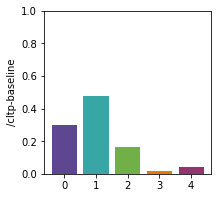

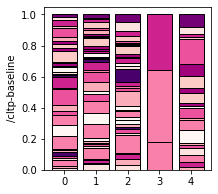

new


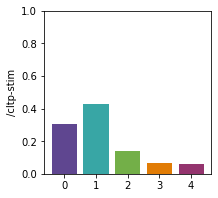

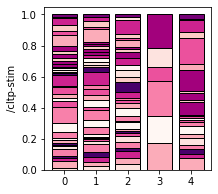

recurrent-before


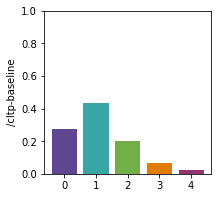

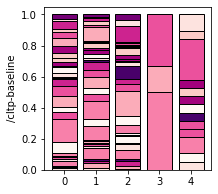

recurrent-after


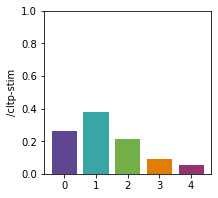

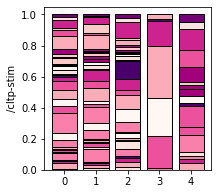

recurrent


In [1390]:
numpy.random.seed(42)
_cmap = pyplot.get_cmap("RdPu", 10)#max(df["neuron-id"].unique()))
COLORS_NEURONS = {
    neuron_id : _cmap(i % 10) for i, neuron_id in enumerate(df["neuron-id"].unique())
}
samples, samples_norm, labels_ = [], [], []
for event_type, conditions in event_types.items():
    print(event_type)
    event_mask = df["event-type"] == event_type
    if not any(event_mask):
        continue
    for condition in conditions:
        condition_mask = df["condition"] == condition
        mask = event_mask * condition_mask
    
        proportion = numpy.zeros(CLUSTERS)
        unique, counts = numpy.unique(labels[mask], return_counts=True)
        proportion[unique] = counts #/ numpy.sum(event_mask)   
        fig, ax = pyplot.subplots(figsize=(3,3))
        ax.bar(numpy.arange(CLUSTERS), proportion / numpy.sum(event_mask), color=[cmap(i) for i in range(CLUSTERS)])
        ax.set(
            ylim=(0, 1.0),
            ylabel=condition,
            xticks = numpy.arange(CLUSTERS), xticklabels=numpy.arange(CLUSTERS)
        )
#         savefig(fig, ax, "./panels/per-event-type/raw_cltp_subtype-distribution_{}_{}".format(event_type, condition.split("-")[-1]), save_white=True)
        pyplot.show()
        
        samples.append(proportion)
        samples_norm.append(proportion / numpy.sum(event_mask))
        labels_.append(f"{condition}_{event_type}")

        neuron_ids = df["neuron-id"][mask]
        tmp_labels = labels[mask]
        fig, ax = pyplot.subplots(figsize=(3,3))
        running = {i : 0 for i in range(CLUSTERS)}
        for i in range(CLUSTERS):
            neuron_mask = neuron_ids[tmp_labels == i]
            for uid, c in zip(*numpy.unique(neuron_mask, return_counts=True)):
                c /= len(neuron_mask)
                ax.bar(i, c, bottom=running[i], color=COLORS_NEURONS[uid], edgecolor="black")
                running[i] += c
        ax.set(
#             ylim=(0, 1),
            ylabel=condition,
            xticks = numpy.arange(CLUSTERS), xticklabels=numpy.arange(CLUSTERS)
        )                
#         savefig(fig, ax, "./panels/per-event-type/raw_cltp_movie-distribution_{}_{}".format(event_type, condition.split("-")[-1]), save_white=True)
        pyplot.show()

['/cltp-baseline_silenced', '/cltp-baseline_recurrent-before']


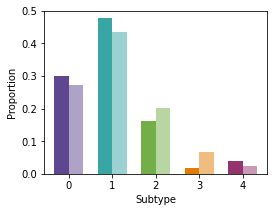

['/cltp-stim_new', '/cltp-stim_recurrent-after']


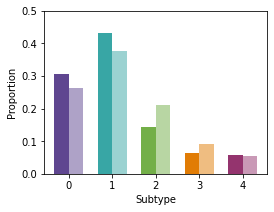

['/cltp-baseline_silenced', '/cltp-stim_new']


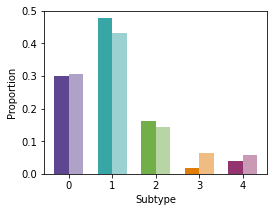

['/cltp-baseline_recurrent-before', '/cltp-stim_recurrent-after']


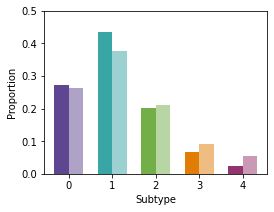

In [1396]:
COMPARE_CONDITIONS = {
    "before" : ["/cltp-baseline_silenced", "/cltp-baseline_recurrent-before"],
    "after" : ["/cltp-stim_new", "/cltp-stim_recurrent-after"],
    "before-after" : ["/cltp-baseline_silenced", "/cltp-stim_new"],
    "recurrent-before-after" : ["/cltp-baseline_recurrent-before", "/cltp-stim_recurrent-after"],    
}
for condition, labels_to_compare in COMPARE_CONDITIONS.items():
    print(labels_to_compare)
    fig, ax = pyplot.subplots(figsize=(4,3))
    widths = 1 / (len(labels_to_compare) + 1)
    for n, label_to_compare in enumerate(labels_to_compare):
        observations = samples_norm[labels_.index(label_to_compare)]
        for i, obs in enumerate(observations):
            ax.bar(i + (n * widths), obs, color=cmap(i), width=widths, alpha=1 - (n / len(labels_to_compare)))
    ax.set(
        ylim=(0, 0.5), ylabel="Proportion",
        xlabel="Subtype", xticks=numpy.arange(CLUSTERS) + widths / len(labels_to_compare),
        xticklabels=numpy.arange(CLUSTERS)
    )
#     savefig(fig, ax, "./panels/per-event-type/proportion_cltp_subtype-distribution_{}".format(condition), save_white=True)    
    pyplot.show()

In [1399]:
print(samples)
print(labels_)
COMPARE_CONDITIONS = {
    "before" : ["/cltp-baseline_silenced", "/cltp-baseline_recurrent-before"],
    "after" : ["/cltp-stim_new", "/cltp-stim_recurrent-after"],
    "before-after" : ["/cltp-baseline_silenced", "/cltp-stim_new"],
    "recurrent-before-after" : ["/cltp-baseline_recurrent-before", "/cltp-stim_recurrent-after"],    
#     "silenced" : ['/ctrl-baseline_silenced', '/cltp-baseline_silenced'],
#     "new" : ['/ctrl-stim_new', '/cltp-stim_new'],
#     "recurrent-before" : ['/ctrl-baseline_recurrent', '/cltp-baseline_recurrent'],
#     "recurrent-after" : ['/ctrl-stim_recurrent', '/cltp-stim_recurrent']
}

def chi2_stats(observed_a, observed_b):
    if not isinstance(observed_a, numpy.ndarray):
        observed_a = numpy.array(observed_a)
    if not isinstance(observed_b, numpy.ndarray):
        observed_b = numpy.array(observed_b)

    total = observed_a + observed_b
    total_a, total_b = numpy.sum(observed_a), numpy.sum(observed_b)
    proportion_a = observed_a / total
    proportion_b = observed_b / total    
    
    expected_a = total / numpy.sum(total) * total_a
    expected_b = total / numpy.sum(total) * total_b
    difference_a = observed_a - expected_a
    difference_b = observed_b - expected_b
    
    assert numpy.sum(difference_a) < 1e-8 and numpy.sum(difference_b) < 1e-8
    
    chi2_a = numpy.sum(difference_a ** 2 / expected_a)
    chi2_b = numpy.sum(difference_b ** 2 / expected_b)
    
    chi2 = chi2_a + chi2_b

    pvalue = 1 - stats.chi2.cdf(chi2, df=(2 - 1) * (len(observed_a) - 1))   
    return chi2, pvalue
    
FDR = 0.05
for condition, labels_to_compare in COMPARE_CONDITIONS.items():
    print("\n", labels_to_compare)
    observed_a = samples[labels_.index(labels_to_compare[1])]
    observed_b = samples[labels_.index(labels_to_compare[0])]

    chi2, pvalue = chi2_stats(observed_a, observed_b)
    print(condition, pvalue)
    if pvalue < 0.05:
        # Post-Hoc; Compare between bins
        pvalues = []
        for i in range(len(observed_a)):
            mask = numpy.setdiff1d(numpy.arange(len(observed_a)), [i])
            _, pvalue = chi2_stats([observed_a[i], numpy.sum(observed_a[mask])], [observed_b[i], numpy.sum(observed_b[mask])])
            pvalues.append(pvalue)
        pvalues = numpy.array(pvalues)
        print(pvalues)
        print(pvalues < 0.05)
        
        # Benjamini-Hochberg
        argsorted = numpy.argsort(pvalues)
        correction = pvalues[argsorted] < (numpy.arange(len(pvalues)) + 1) / len(observed_a) * FDR
        minimal_p = pvalues[argsorted[max(numpy.nonzero(correction)[0])]] # last pvalue
#         print(pvalues, pvalues < minimal_p)

[array([470., 747., 255.,  28.,  63.]), array([553., 781., 259., 115., 107.]), array([220., 350., 162.,  54.,  19.]), array([214., 306., 172.,  74.,  44.])]
['/cltp-baseline_silenced', '/cltp-stim_new', '/cltp-baseline_recurrent-before', '/cltp-stim_recurrent-after']

 ['/cltp-baseline_silenced', '/cltp-baseline_recurrent-before']
before 5.159489502304382e-10
[1.64362431e-01 4.61058977e-02 2.11480553e-02 5.69741920e-10
 3.52037620e-02]
[False  True  True  True  True]

 ['/cltp-stim_new', '/cltp-stim_recurrent-after']
after 5.568869858363357e-06
[3.51336971e-02 1.16159694e-02 8.61804620e-06 1.03699668e-02
 6.37778791e-01]
[ True  True  True  True False]

 ['/cltp-baseline_silenced', '/cltp-stim_new']
before-after 7.242184629774329e-11
[8.01831759e-01 5.55678596e-03 9.89834248e-02 6.11097839e-11
 1.34477762e-02]
[False  True False  True  True]

 ['/cltp-baseline_recurrent-before', '/cltp-stim_recurrent-after']
recurrent-before-after 0.002567808826230644
[0.68017704 0.01968696 0.5817337  

silenced


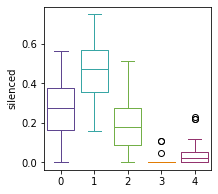

new


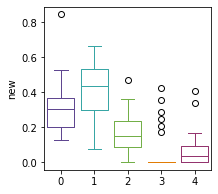

recurrent-before


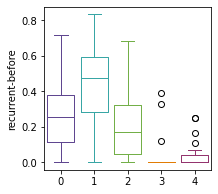

recurrent-after


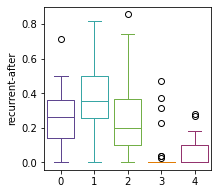

recurrent


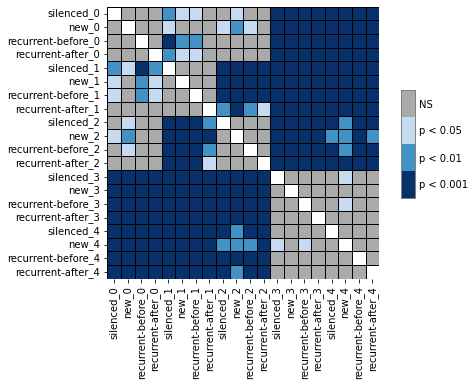

In [996]:
samples, labels_ = [], []
for event_type, conditions in event_types.items():
    print(event_type)
    event_mask = df["event-type"] == event_type
    if not any(event_mask):
        continue
        
    per_neuron = []    
    for condition in conditions:
        
        condition_mask = df["condition"] == condition
        mask = condition_mask * event_mask
        for neuron_id in KEEP_NEURON[condition]:
            condition_mask = df["condition"] == condition
            event_mask = df["event-type"] == event_type
            neuron_mask = df["neuron-id"] == neuron_id
            
            mask = condition_mask.values * event_mask.values * neuron_mask.values

            proportion = numpy.zeros(CLUSTERS)
            unique, counts = numpy.unique(labels[mask], return_counts=True)
            proportion[unique] = counts / numpy.sum(counts)      
            per_neuron.append(proportion)
            
    per_neuron = numpy.array(per_neuron)
    
    fig, ax = pyplot.subplots(figsize=(3,3))
    for i in range(CLUSTERS):
        bplot = ax.boxplot(per_neuron[:, i], positions=[i], widths=0.8)
        for part, items in bplot.items():
            for item in items:
                item.set_color(cmap(i))
    ax.set(
#         ylim=(0, 1), 
        ylabel=event_type,
        xticks = numpy.arange(CLUSTERS), xticklabels=numpy.arange(CLUSTERS)
    )
    pyplot.show()
    
    for i in range(CLUSTERS):
        samples.append(per_neuron[:, i])
        labels_.append(f"{event_type}_{i}")

tmp = sorted(zip(labels_, samples), key=lambda x: int(x[0].split("_")[-1]))
labels_, samples = zip(*tmp)
labels_, samples = list(labels_), list(samples)        

_, pvalues = get_significance(samples, labels_)
fig, ax = plot_pvalues(pvalues)
pyplot.show()


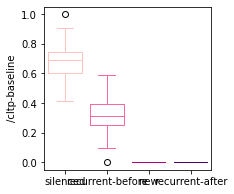

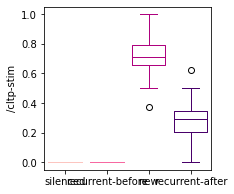

The standardize residuals are normaly distributed.
The null hypothesis can be rejected from the ANOVA one way test.
	pvalue : 7.222125023492428e-20
Posthoc ttest is computed on the data
Posthoc t-test results
	pvalues :               1             2
1  1.000000e+00  7.222125e-20
2  7.222125e-20  1.000000e+00
The standardize residuals are normaly distributed.
The null hypothesis can be rejected from the ANOVA one way test.
	pvalue : 3.4072369366788306e-23
Posthoc ttest is computed on the data
Posthoc t-test results
	pvalues :               1             2
1  1.000000e+00  3.407237e-23
2  3.407237e-23  1.000000e+00
The standardize residuals are normaly distributed.
The one-way ANOVA test that two or more groups have the same population mean cannot be rejected with alpha confidence of 0.05.
	pvalue : 0.25251305587137896
The standardize residuals are normaly distributed.
The one-way ANOVA test that two or more groups have the same population mean cannot be rejected with alpha confidence of

In [999]:
# Per event-type and images
samples, labels_ = [], []

per_neuron = []    

mask = df["event-type"] != -1
y = df.loc[:, "event-type"][mask]
y, unique_y = pandas.factorize(y)
unique_y = unique_y.tolist()
cmap = pyplot.get_cmap("nice-prism", len(unique_y))
cmap = pyplot.get_cmap("RdPu", 4 + 1)

for condition in df["condition"].unique():
    
    if not "cltp" in condition:
        continue

    condition_mask = df["condition"] == condition
    mask = condition_mask
    per_neuron = {}
    for neuron_id in KEEP_NEURON[condition]:
        condition_mask = df["condition"] == condition
        neuron_mask = df["neuron-id"] == neuron_id

        mask = condition_mask.values * neuron_mask.values

        unique, counts = numpy.unique(df["event-type"][mask], return_counts=True)
        proportion = numpy.zeros(len(unique_y))
        for u, c in zip(unique, counts):
            if u in unique_y:
                proportion[unique_y.index(u)] = c
        proportion /= proportion.sum()
        per_neuron[neuron_id] = proportion
    
    # Orders neurons
    order = list(sorted(per_neuron.keys()))
    per_neuron = [per_neuron[key] for key in order]
    
    per_neuron = numpy.array(per_neuron)

    fig, ax = pyplot.subplots(figsize=(3,3))
    for i in range(len(unique_y)):
        bplot = ax.boxplot(per_neuron[:, i], positions=[i], widths=0.8)
        for part, items in bplot.items():
            for item in items:
                item.set_color(cmap(i + 1))
    ax.set(
#         ylim=(0, 1), 
        ylabel=condition,
        xticks=numpy.arange(len(unique_y)), xticklabels=unique_y
    )
    pyplot.show()
    
    for i, unique in enumerate(unique_y):
        samples.append(per_neuron[:, i])
        labels_.append(f"{condition}_{i}")

# # Everyting together; problem with zeros distribution
# _, pvalues = get_significance(samples, labels_, )
# fig, ax = plot_pvalues(pvalues)
# pyplot.show()

conditions = [
    ["/cltp-baseline_0", "/cltp-baseline_1"], # silenced vs. recurrent before
    ["/cltp-stim_2", "/cltp-stim_3"], # new vs. reccurent after
    ["/cltp-baseline_0", "/cltp-stim_2"],
    ["/cltp-baseline_1", "/cltp-stim_3"],
]
for condition_a, condition_b in conditions:
    sample_a, sample_b = samples[labels_.index(condition_a)], samples[labels_.index(condition_b)]
    
    _, pvalues = get_significance([sample_a, sample_b], [condition_a, condition_b], verbose=True)
    
#     fig, ax = pyplot.subplots(figsize=(3,3))
#     ax.boxplot(fc)
#     ax.axhline(y=0, color="black", linestyle="dashed")
#     pyplot.show()

# Event-type -- classification

(2368, 8)
(array([0, 1]), array([1084,  573]))
0.5560479807069325


Boolean Series key will be reindexed to match DataFrame index.
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names


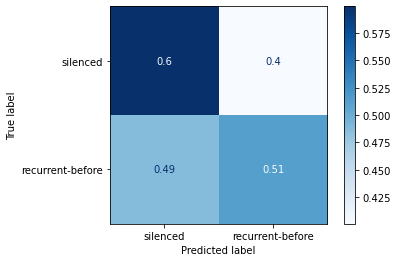

silenced
(711, 8, 2)


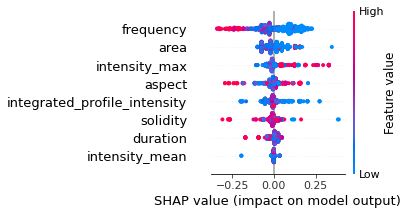

recurrent-before
(711, 8, 2)


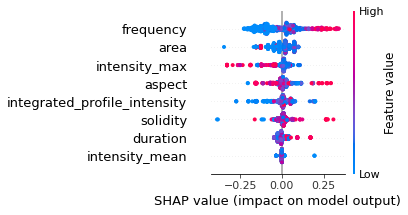

(2625, 8)
(array([0, 1]), array([1248,  589]))
0.640937856624131


Boolean Series key will be reindexed to match DataFrame index.
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names


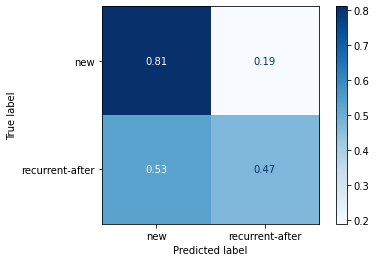

new
(788, 8, 2)


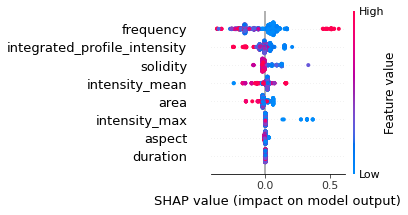

recurrent-after
(788, 8, 2)


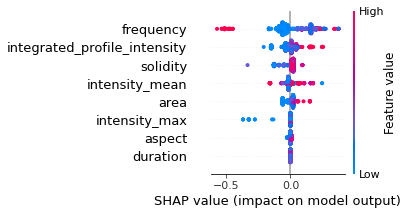

(3378, 8)
(array([0, 1]), array([1068, 1296]))
0.5239504875343026


Boolean Series key will be reindexed to match DataFrame index.
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names


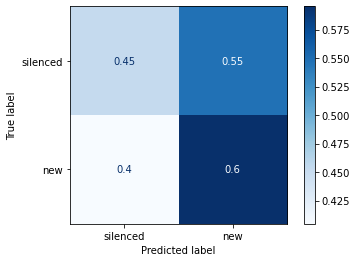

silenced
(1014, 8, 2)


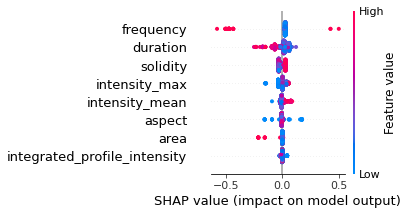

new
(1014, 8, 2)


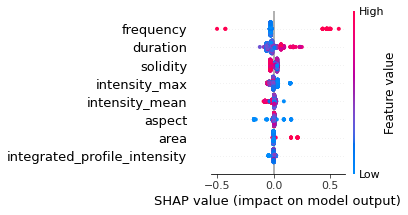

In [1207]:
import shap
shap.initjs()
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, make_scorer, balanced_accuracy_score

# feature_df = df.iloc[:, 7:]
feature_df = df.loc[CLTP_MASK, KEEP_FEATURES]
for event_types in [["silenced", "recurrent-before"], ["new", "recurrent-after"], ["silenced", "new"]]:
    mask = df["event-type"] != -1
    other_mask = pandas.DataFrame(data=numpy.zeros(len(df), dtype=bool)).squeeze()
    for event_type in event_types:
        other_mask += df["event-type"] == event_type
    mask = mask * other_mask

    subdf = feature_df[mask]
    y = df.loc[:, "event-type"][mask]
    y, unique_y = pandas.factorize(y)

    print(subdf.shape)

    X_train, X_test, y_train, y_test = train_test_split(subdf, y, test_size=0.3, random_state=42)
    mean, std = X_train.mean(), X_train.std()
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    print(numpy.unique(y_train, return_counts=True))

    model = sklearn.tree.DecisionTreeClassifier(
        min_samples_split=2, max_depth=5, random_state=42,
        class_weight="balanced"
    )
    model.fit(X_train.values, y_train)
#     parameters = {
#         "max_depth" : [5, 10, 15],
#         "min_samples_split" : [2, 5, 10],
#         "min_samples_leaf" : [1, 5, 10, 25, 50]
#     }
#     weights = len(X_test) / (2 * numpy.bincount(y_train))
#     sample_weight = numpy.zeros(len(y_train))
#     for i, w in enumerate(weights):
#         sample_weight[y_train == i] = w    
#     scorer = make_scorer(balanced_accuracy_score)
#     clf = GridSearchCV(model, parameters, scoring=scorer, refit=True)
#     clf.fit(X_train.values, y_train)    
    
#     model = clf.best_estimator_
#     print(clf.best_params_)
#     print(clf.best_score_)
    
    predictions = model.predict(X_test)
    weights = len(X_test) / (2 * numpy.bincount(y_test))
    sample_weight = numpy.zeros(len(y_test))
    for i, w in enumerate(weights):
        sample_weight[y_test == i] = w
    print(accuracy_score(y_test, predictions, sample_weight=sample_weight))

    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=unique_y,
        cmap=pyplot.cm.Blues,
        normalize="true",
    #     im_kw={"vmin" : 0, "vmax" : 1}
    )
    pyplot.show()

    explainer = shap.TreeExplainer(model, X_train, feature_names=X_train.columns, model_output="probability")
    shap_values = explainer(X_test)

    for class_id in range(len(unique_y)):
        print(unique_y[class_id])

        print(shap_values.shape)
        shap.plots.beeswarm(shap_values[:, :, class_id], show=False, alpha=1.0)
        fig = pyplot.gcf()
        fig.set_size_inches(3, 3)
        ax = pyplot.gca()
        yticklabels = []
        for text in ax.get_yticklabels():
            txt = text.get_text()
            if txt.startswith("Feature"):
                txt = list(subdf.keys())[int(txt.split(" ")[-1])]
            text.set_color("black")
            text.set_text(txt)
            yticklabels.append(text)
        ax.set_yticklabels(yticklabels)
        ax.set_rasterized(False)
        savefig(fig, ax, "./panels/event-type-classification/shap_cltp_{}_{}-{}".format(unique_y[class_id], *event_types), save_white=True)
        pyplot.show()